In [22]:
import pandas as pd
import numpy as np

In [23]:
pd.set_option('display.max_columns', None)

In [24]:
df = pd.read_csv("data\State_lagged.csv")

In [25]:
df

,state,state_id,month_date_yyyymm,median_listing_price,median_listing_price_prev,median_listing_price_mm_prev,median_listing_price_yy_prev,active_listing_count_prev,active_listing_count_mm_prev,active_listing_count_yy_prev,median_days_on_market_prev,median_days_on_market_mm_prev,median_days_on_market_yy_prev,new_listing_count_prev,new_listing_count_mm_prev,new_listing_count_yy_prev,price_increased_count_prev,price_increased_count_mm_prev,price_increased_count_yy_prev,price_increased_share_prev,price_increased_share_mm_prev,price_increased_share_yy_prev,price_reduced_count_prev,price_reduced_count_mm_prev,price_reduced_count_yy_prev,price_reduced_share_prev,price_reduced_share_mm_prev,price_reduced_share_yy_prev,pending_listing_count_prev,pending_listing_count_mm_prev,pending_listing_count_yy_prev,median_listing_price_per_square_foot_prev,median_listing_price_per_square_foot_mm_prev,median_listing_price_per_square_foot_yy_prev,median_square_feet_prev,median_square_feet_mm_prev,median_square_feet_yy_prev,average_listing_price_prev,average_listing_price_mm_prev,average_listing_price_yy_prev,total_listing_count_prev,total_listing_count_mm_prev,total_listing_count_yy_prev,pending_ratio_prev,pending_ratio_mm_prev,pending_ratio_yy_prev,Region_prev,Division_prev,median_listing_price_lag6,median_listing_price_lag12
0,Alaska,AK,2017-08-01,279000,279375.0,-0.006667,-0.0333,3710.0,0.092784,-0.0196,53.0,0.104167,-0.1452,1368.0,-0.066849,0.1176,40.0,0.666667,0.1111,0.0077,0.571429,0.0002,1232.0,0.120000,-0.0096,0.2407,0.084723,-0.0009,0.0,0.000000,0.0000,164.0,0.000000,0.0015,1750.0,0.005747,-0.0278,327328.0,-0.003374,-0.0121,3710.0,0.092784,-0.0196,0.0000,0.000000,0.0000,West,Pacific,-1.0,-1.0
1,Alaska,AK,2017-09-01,275000,279000.0,-0.001342,-0.0258,3932.0,0.059838,0.0523,60.0,0.132075,-0.1111,1354.0,-0.010234,0.2514,22.0,-0.450000,-0.5217,0.0041,-0.467532,-0.0054,1372.0,0.113636,0.0872,0.2681,0.113835,0.0085,0.0,0.000000,0.0000,163.0,-0.006098,-0.0056,1746.0,-0.002286,-0.0218,323716.0,-0.011035,-0.0155,3932.0,0.059838,0.0518,0.0000,0.000000,0.0000,West,Pacific,-1.0,-1.0
2,Alaska,AK,2017-10-01,274900,275000.0,-0.014337,-0.0342,3878.0,-0.013733,0.0670,67.0,0.116667,-0.0563,1064.0,-0.214180,0.1849,12.0,-0.454545,-0.3333,0.0037,-0.097561,-0.0004,1220.0,-0.110787,0.0758,0.2494,-0.069750,0.0063,1.0,0.000000,-0.7500,161.0,-0.012270,-0.0125,1729.0,-0.009737,-0.0300,318701.0,-0.015492,-0.0236,3879.0,-0.013479,0.0660,0.0003,-0.250000,-0.0008,West,Pacific,-1.0,-1.0
3,Alaska,AK,2017-11-01,269900,274900.0,-0.000364,-0.0179,3648.0,-0.059309,0.1065,76.0,0.134328,-0.0380,820.0,-0.229323,0.0406,20.0,0.666667,-0.1667,0.0045,0.216216,-0.0016,992.0,-0.186885,0.1071,0.2211,-0.113472,0.0049,1.0,0.000000,-0.7500,161.0,0.000000,-0.0115,1735.0,0.003470,-0.0167,318834.0,0.000417,-0.0246,3649.0,-0.059294,0.1054,0.0003,0.000000,-0.0009,West,Pacific,-1.0,-1.0
4,Alaska,AK,2017-12-01,267950,269900.0,-0.018188,-0.0350,3417.0,-0.063322,0.1455,85.0,0.118421,-0.0230,716.0,-0.126829,0.1933,22.0,0.100000,0.8333,0.0056,0.244444,0.0021,798.0,-0.195565,0.2353,0.1912,-0.135233,0.0134,1.0,0.000000,-0.7143,162.0,0.006211,-0.0071,1705.0,-0.017291,-0.0332,315253.0,-0.011232,-0.0398,3418.0,-0.063305,0.1445,0.0003,0.000000,-0.0009,West,Pacific,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4840,Wyoming,WY,2025-02-01,459725,459925.0,-0.000163,0.0575,1914.0,-0.064059,0.1022,89.0,0.047059,0.0028,560.0,0.176471,0.1200,18.0,2.000000,0.8000,0.0064,1.782609,0.0025,298.0,0.295652,0.2314,0.1046,0.327411,0.0108,371.0,-0.048718,0.0320,205.0,-0.004854,0.1088,2204.0,0.001363,-0.0224,1166665.0,0.008918,0.2384,2282.0,-0.062063,0.0908,0.1936,0.016273,-0.0132,West,Mountain,485290.0,449450.0
4841,Wyoming,WY,2025-03-01,459900,459725.0,-0.000435,0.0229,1834.0,-0.041797,0.0956,88.0,-0.011236,-0.0112,594.0,0.060714,0.0919,0.0,-1.000000,-1.000

In [4]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
encode_cols = ["state", "state_id", "Region_prev", "Division_prev"]
df2 = df.copy()
# Initialize encoder
le_dict = {}
for col in encode_cols:
    le = LabelEncoder()
    df2[col] = le.fit_transform(df2[col])
    le_dict[col] = le   # store encoders if you need to inverse_transform later

In [5]:
df2['month_date_yyyymm'] = pd.to_datetime(df2['month_date_yyyymm'])
df2['year'] = df2['month_date_yyyymm'].dt.year
df2['month'] = df2['month_date_yyyymm'].dt.month
df2.drop(columns=['month_date_yyyymm'], inplace=True)

In [7]:
df2.drop(columns=['state'], inplace=True, errors='ignore')

In [8]:
label = 'median_listing_price' 
X = df2.drop(columns=[label], axis=1)  
y = df2[label]

X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

In [16]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import numpy as np
import gc
import warnings
warnings.filterwarnings("ignore")

def get_model_predictions(X, y, model_func):
    val_preds = np.zeros(len(X))
    cv = KFold(n_splits=10, shuffle=True, random_state=9)

    # Lists to store fold metrics
    rmse_list = []
    mae_list = []
    r2_list = []

    for fold, (train_ind, valid_ind) in enumerate(cv.split(X, y)):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[valid_ind], y.iloc[valid_ind]

        model = model_func()

        # Fit based on model type
        if model_func == lgb_model:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(-1)]
            )
        elif model_func == xgb_model:
            model.fit(
                X_train, y_train,
                eval_set=[(X_val, y_val)],
                verbose=0
            )
        elif model_func == catboost_model:
            model.fit(
                X_train, y_train,
                eval_set=(X_val, y_val),
                cat_features=[0, 43, 44]
            )
        else:  # RF and ET
            model.fit(X_train, y_train)

        gc.collect()

        y_pred_val = model.predict(X_val)
        y_pred_val = y_pred_val.round()

        # Evaluate
        rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
        mae = mean_absolute_error(y_val, y_pred_val)
        r2 = r2_score(y_val, y_pred_val)

        rmse_list.append(rmse)
        mae_list.append(mae)
        r2_list.append(r2)

        print("-" * 60)
        print(f"{model_func.__name__} Fold {fold}")
        print(f"RMSE: {rmse:.4f} | MAE: {mae:.4f} | R2: {r2:.4f}")
        print("-" * 60)
        
        val_preds[valid_ind] = y_pred_val
        gc.collect()

    # Print average metrics across folds
    print("=" * 60)
    print(f"{model_func.__name__} CV Average Metrics:")
    print(f"RMSE: {np.mean(rmse_list):.4f} | MAE: {np.mean(mae_list):.4f} | R2: {np.mean(r2_list):.4f}")
    print("=" * 60)

    return val_preds, rmse_list

In [17]:
def lgb_model():
    return lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.1, device='gpu')

def xgb_model():
    return xgb.XGBRegressor(
        n_estimators=1000,
        tree_method='gpu_hist',
        predictor='gpu_predictor',
        objective='reg:squarederror',
        random_state=42
    )
    
def catboost_model():
    return CatBoostRegressor(
        iterations=1000,
        loss_function='RMSE',
        random_seed=42,
        task_type='GPU',
        eval_metric='RMSE',
        verbose=0
    )
    
def rf_model():
    return RandomForestRegressor(
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

def et_model():
    return ExtraTreesRegressor(
        random_state=42,
        n_jobs=-1,
        verbose=0
    )

In [18]:
cat_cols = [
    'state_id', 'Region_prev', 'Division_prev'
]

for col in cat_cols:
    X[col] = X[col].astype(str)
    
# 1. Convert to category dtype
X[cat_cols] = X[cat_cols].astype('category')

# 2. Get categorical feature indices for CatBoost
cat_feature_indices = [X.columns.get_loc(col) for col in cat_cols]

print("CatBoost categorical feature indices:", cat_feature_indices)

CatBoost categorical feature indices: [0, 43, 44]


In [19]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# Fit on training features
X_scaled = scaler.fit_transform(X)

# Optional: convert back to DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [20]:
rmse_results = {}

In [21]:
print("1. XGBRegressor")
xgb_val_preds, xgb_rmse_list = get_model_predictions(X_scaled, y, xgb_model)
rmse_results["XGBRegressor"] = xgb_rmse_list

1. XGBRegressor
------------------------------------------------------------
xgb_model Fold 0
RMSE: 7184.3758 | MAE: 4602.8433 | R2: 0.9975
------------------------------------------------------------
------------------------------------------------------------
xgb_model Fold 1
RMSE: 6829.7303 | MAE: 4602.2207 | R2: 0.9980
------------------------------------------------------------
------------------------------------------------------------
xgb_model Fold 2
RMSE: 6433.5654 | MAE: 4593.7358 | R2: 0.9979
------------------------------------------------------------
------------------------------------------------------------
xgb_model Fold 3
RMSE: 7279.5236 | MAE: 4979.8682 | R2: 0.9976
------------------------------------------------------------
------------------------------------------------------------
xgb_model Fold 4
RMSE: 6565.7179 | MAE: 4432.0537 | R2: 0.9978
------------------------------------------------------------
-----------------------------------------------------------

In [22]:
print("2. LGBMRegressor")
lgb_val_preds, lgb_rmse_list = get_model_predictions(X_scaled, y, lgb_model)
rmse_results["LGBMRegressor"] = lgb_rmse_list

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11157
[LightGBM] [Info] Number of data points in the train set: 4360, number of used features: 49
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 with Max-Q Design, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 49 dense feature groups (0.22 MB) transferred to GPU in 0.002932 secs. 0 sparse feature groups
[LightGBM] [Info] Start training from score 371870.252064
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[426]	valid_0's l2: 3.91169e+07
------------------------------------------------------------
lgb_model Fold 0
RMSE: 6254.3260 | MAE: 4121.5979 | R2: 0.9981
------------------------------------------------------------
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11157
[Ligh

In [24]:
print("3. CatBoostRegressor")
cat_val_preds, cat_rmse_list = get_model_predictions(X, y, catboost_model)
rmse_results["CatBoostRegressor"] = cat_rmse_list

3. CatBoostRegressor
------------------------------------------------------------
catboost_model Fold 0
RMSE: 7766.6367 | MAE: 5314.8103 | R2: 0.9970
------------------------------------------------------------
------------------------------------------------------------
catboost_model Fold 1
RMSE: 8134.7581 | MAE: 5562.9649 | R2: 0.9972
------------------------------------------------------------
------------------------------------------------------------
catboost_model Fold 2
RMSE: 6534.4349 | MAE: 4583.5485 | R2: 0.9979
------------------------------------------------------------
------------------------------------------------------------
catboost_model Fold 3
RMSE: 7324.4324 | MAE: 5082.3526 | R2: 0.9976
------------------------------------------------------------
------------------------------------------------------------
catboost_model Fold 4
RMSE: 7602.1158 | MAE: 5125.5876 | R2: 0.9971
------------------------------------------------------------
-----------------------------

In [25]:
print("4. ExtraTreesRegressor")
et_val_preds, et_rmse_list = get_model_predictions(X_scaled, y, et_model)
rmse_results["ExtraTreesRegressor"] = et_rmse_list

4. ExtraTreesRegressor
------------------------------------------------------------
et_model Fold 0
RMSE: 6414.3672 | MAE: 4108.6227 | R2: 0.9980
------------------------------------------------------------
------------------------------------------------------------
et_model Fold 1
RMSE: 6650.4605 | MAE: 4483.9052 | R2: 0.9981
------------------------------------------------------------
------------------------------------------------------------
et_model Fold 2
RMSE: 6081.8730 | MAE: 4244.9361 | R2: 0.9981
------------------------------------------------------------
------------------------------------------------------------
et_model Fold 3
RMSE: 7125.4560 | MAE: 4622.2433 | R2: 0.9977
------------------------------------------------------------
------------------------------------------------------------
et_model Fold 4
RMSE: 5834.5653 | MAE: 4009.1443 | R2: 0.9983
------------------------------------------------------------
---------------------------------------------------------

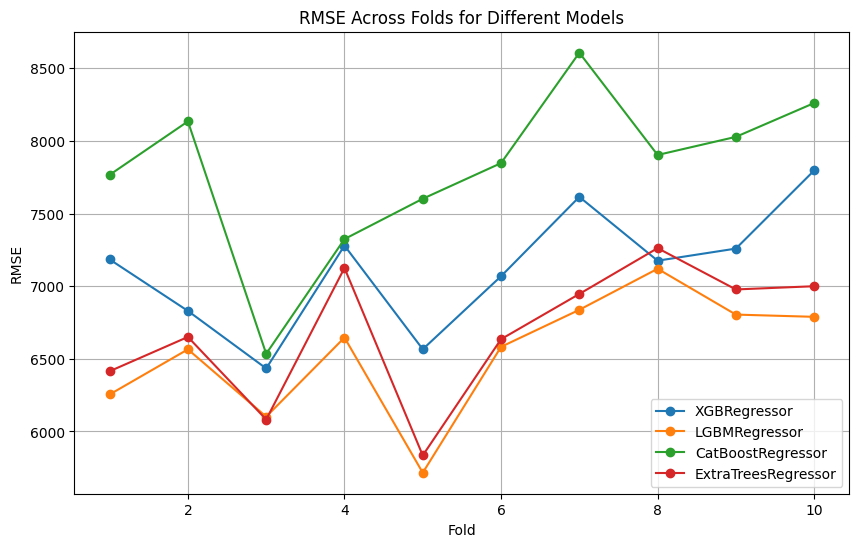

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for model_name, rmses in rmse_results.items():
    plt.plot(range(1, len(rmses)+1), rmses, marker='o', label=model_name)

plt.xlabel("Fold")
plt.ylabel("RMSE")
plt.title("RMSE Across Folds for Different Models")
plt.legend()
plt.grid(True)
plt.show()